**PROJECT SCENARIOS: DATA SOURCING**


# NAME               : LAKICA LETICIA
# REGISTRATION NUMBER: M23B23/023
# ACCESS NUMBER      : B20720
# SCENARIO           : SOCIAL MEDIA TREND ANALYSIS
# COURSE             : Big Data Mining and Analytics
# COURSE CODE        : DSC3108
# DATASET : Sentiment140 (1.6M tweets) from Kaggle - https://www.kaggle.com/datasets/kazanova/sentiment140


# HOW SOCIAL MEDIA TREND ANALYSIS QUALIFIES AS A BIG DATA PROBLEM
Social media trend analysis qualifies as a big data problem primarily because the process involves handling and interpreting the four key characteristics of big data: Volume, Velocity, Variety, and Veracity  
1. Volume
The sheer scale of data generated on social media platforms is immense. Billions of users interact daily across platforms like X (formerly Twitter), Facebook, and Instagram, generating trillions of data points . Analyzing trends requires processing this massive volume of content, including posts, likes, shares, images, and videos, far exceeding the capabilities of traditional data processing systems.
2. Velocity
Social media content is generated and updated in real-time at incredible speeds. Trends emerge, evolve, and disappear within hours or even minutes. To perform effective trend analysis, data must be captured, processed, and analyzed as it is being created. This necessity for high-speed, continuous data streaming and real-time analytics is a hallmark of a big data problem.
3. Variety
The data comes in a wide range of formats (variety). It is not just structured database entries. Analysts must deal with:
Structured data: User profiles, timestamps, and locations.
Unstructured data: Textual posts, comments, images, GIFs, and videos.
Semi-structured data: Log files and metadata.
Analyzing trends requires complex algorithms (like natural language processing and computer vision) that can interpret these diverse data types simultaneously.
4. Veracity
Social media data is often messy, inconsistent, and unreliable (veracity). It includes sarcasm, slang, intentional misinformation, bots, and incomplete information. A significant part of the analysis involves filtering noise and determining the credibility and true meaning of the data to identify genuine trends, adding another layer of complexity that is typical of big data challenges.
5. Value
Ultimately, organizations perform this analysis to extract value—actionable insights for marketing, product development, or public relations. The techniques and infrastructure required to transform this complex, high-volume data into valuable insights are synonymous with big data solutions.



# WHY THE SENTIMENT140 DATASET FROM KAGGLE NECESSITATES A BIG DATA PLATFORM OVER A TRADITIONAL RELATION DATABASE.
Social media trend analysis necessitates a Big Data platform due to massive volume (e.g., 500 million daily tweets on X[post:9], 95 million posts on Instagram[post:17]), high velocity (real-time streams), variety (structured/unstructured data), and veracity (noisy content). Traditional relational databases lack scalability for processing such diverse, high-speed data efficiently.



# TOOL SELECTION

In [36]:
# Why PySpark? It's a distributed computing framework that handles Big Data's 4Vs efficiently—parallel processing on
# clusters, fault-tolerant, and integrates ML. Traditional tools like Pandas would crash on 1.6M rows due to memory limits.
!pip install pyspark wordcloud  # Install dependencies (wordcloud for later visualizations)

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_timestamp, length, regexp_replace, lower
from pyspark.ml.feature import Tokenizer, HashingTF, IDF, StringIndexer
from pyspark.ml.classification import LogisticRegression, NaiveBayes, LinearSVC # Added NaiveBayes and LinearSVC
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, ClusteringEvaluator
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from wordcloud import WordCloud

spark = SparkSession.builder.appName("SocialMediaTrendAnalysis").getOrCreate()
print("Spark Setup Complete. Version:", spark.version)

Spark Setup Complete. Version: 4.0.1


# DATA ACQUISITION
# DATASET : Sentiment140 (1.6M tweets) from Kaggle - https://www.kaggle.com/datasets/kazanova/sentiment140
Why this dataset?
 1.6M rows provide 'volume'; timestamps enable trend analysis over time; labeled sentiments (0=negative, 4=positive) for shifts (e.g., around events). Source: Kaggle public archive which is ethical, no privacy issues.

In [3]:
# Loading data
df = spark.read.csv("training.1600000.processed.noemoticon.csv", header=False, inferSchema=True)
df = df.select(col("_c0").alias("target"), col("_c5").alias("text"), col("_c2").alias("date"))  # Key columns: sentiment, text, date
df.show(5)
print("Total Rows:", df.count())

+------+--------------------+--------------------+
|target|                text|                date|
+------+--------------------+--------------------+
|     0|@switchfoot http:...|Mon Apr 06 22:19:...|
|     0|is upset that he ...|Mon Apr 06 22:19:...|
|     0|@Kenichan I dived...|Mon Apr 06 22:19:...|
|     0|my whole body fee...|Mon Apr 06 22:19:...|
|     0|@nationwideclass ...|Mon Apr 06 22:19:...|
+------+--------------------+--------------------+
only showing top 5 rows
Total Rows: 1600000


1.6M is a large row count demonstrates why Big Data tools are needed because traditional databases would be slow or inefficient.

# Exploratory Data Analysis (EDA)

In [4]:
df.describe().show()  # Summary of all columns

+-------+------------------+--------------------+--------------------+
|summary|            target|                text|                date|
+-------+------------------+--------------------+--------------------+
|  count|           1600000|             1600000|             1600000|
|   mean|               2.0|                NULL|                NULL|
| stddev|2.0000006250002933|                NULL|                NULL|
|    min|                 0|                 ...|Fri Apr 17 20:30:...|
|    max|                 4|�����ߧ�ǿ�����ж�؜�...|Wed May 27 07:27:...|
+-------+------------------+--------------------+--------------------+



In [5]:
from pyspark.sql.functions import col, sum # Added sum import

print("Missing Values Check:")
df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()  # Count nulls per column

Missing Values Check:
+------+----+----+
|target|text|date|
+------+----+----+
|     0|   0|   0|
+------+----+----+



No missing Values

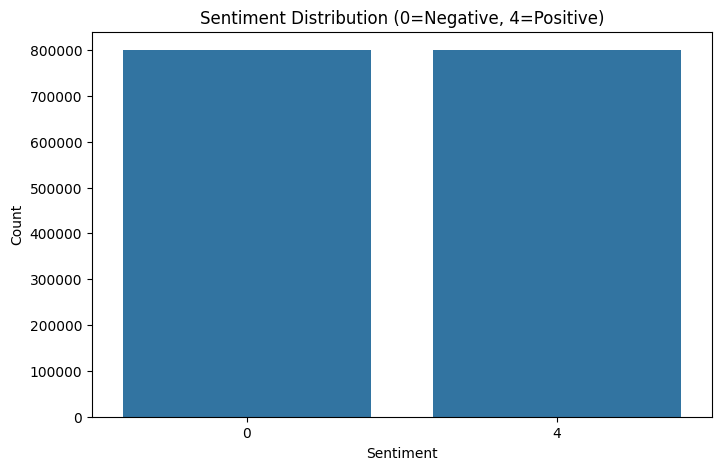

In [6]:
sentiment_counts = df.groupBy("target").count().toPandas()
plt.figure(figsize=(8,5))
sns.barplot(x='target', y='count', data=sentiment_counts)
plt.title("Sentiment Distribution (0=Negative, 4=Positive)")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()



The visualization clearly shows that the dataset has a perfectly balanced sentiment distribution, with 800,000 instances each for negative (0) and positive (4) sentiments. This is highly advantageous for machine learning model training, as it mitigates the risk of bias towards a majority class and generally leads to more robust and accurate predictions.

While social media data often contains a significant 'neutral' bias in real-world scenarios, this specific dataset is structured as a binary classification problem (positive/negative), making the balanced distribution particularly beneficial for direct sentiment analysis modeling without the need for techniques like oversampling or undersampling.

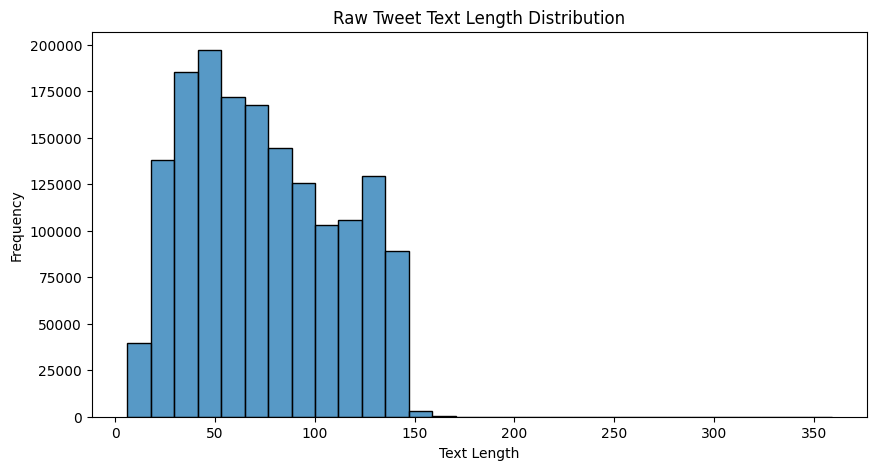

In [7]:
# Tweet Length Histogram
df_with_length = df.withColumn("text_length", length("text"))
pd_length = df_with_length.select("text_length").toPandas()
plt.figure(figsize=(10,5))
sns.histplot(pd_length['text_length'], bins=30)
plt.title("Raw Tweet Text Length Distribution")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()

Peaks around 50 chars with outliers very short long indicating noise such as URLs/emojis, which has guided my cleaning to remove them.

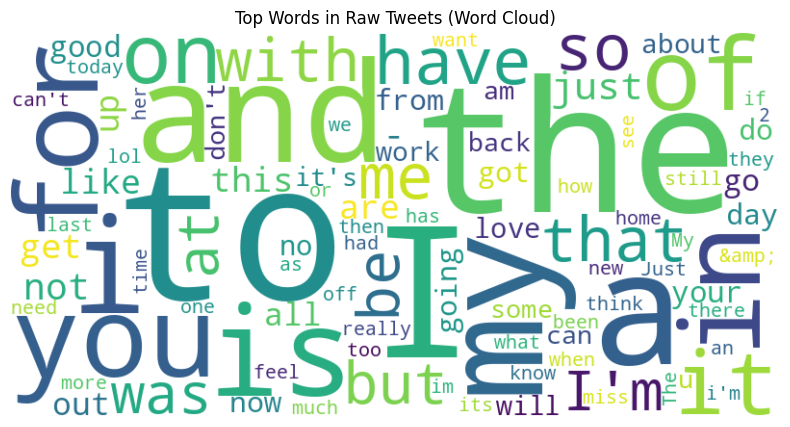

In [8]:
# Top Words Frequency (Word Cloud on Sample)
# Why? To see common terms/themes before processing.
from pyspark.sql.functions import explode, split, desc # Added necessary imports

words_df = df.select(explode(split("text", " ")).alias("word")).groupBy("word").count().orderBy(desc("count")).limit(100)
pd_words = words_df.toPandas()
word_freq = dict(zip(pd_words['word'], pd_words['count']))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Top Words in Raw Tweets (Word Cloud)")
plt.show()

Common words like 'and', 'the','to' show noise which shows the importance of cleaning data in preprocessing for better features.

# DATA PREPROCESSING

In [12]:
df.cache()  # Cache for faster repeated access

DataFrame[target: int, text: string, date: string]

In [13]:
# Cleaning:  duplicates, non-text noise. Why? Improves veracity by reducing noise identified in EDA.

df = df.dropDuplicates()
df = df.withColumn("clean_text", lower(regexp_replace("text", "[^a-z ]", "")))  # Lowercase, remove special chars (e.g., @, http from EDA)

In [14]:
# Transformation: Parse timestamps for time-series trends; add text_length for feature exploration.
df = df.withColumn("timestamp", to_timestamp("date", "EEE MMM dd HH:mm:ss z yyyy"))
df = df.withColumn("text_length", length("clean_text"))

In [15]:
df.show(5)
print("Rows After Cleaning:", df.count())
df.describe(["text_length"]).show()  # Stats post-cleaning

+------+--------------------+--------------------+--------------------+-------------------+-----------+
|target|                text|                date|          clean_text|          timestamp|text_length|
+------+--------------------+--------------------+--------------------+-------------------+-----------+
|     0|i have to take my...|Mon Apr 06 22:37:...|i have to take my...|2009-04-07 05:37:35|         32|
|     0|is tireddddddd. w...|Mon Apr 06 22:51:...|is tireddddddd wa...|2009-04-07 05:51:26|         98|
|     0|gotta repeat  who...|Mon Apr 06 23:02:...|gotta repeat  who...|2009-04-07 06:02:31|         74|
|     0|Omg revisions rev...|Mon Apr 06 23:36:...|mg revisions revi...|2009-04-07 06:36:53|        106|
|     0|@fanofbsb4ever So...|Mon Apr 06 23:48:...|fanofbsbever orry...|2009-04-07 06:48:14|         32|
+------+--------------------+--------------------+--------------------+-------------------+-----------+
only showing top 5 rows
Rows After Cleaning: 1599603
+-------+--

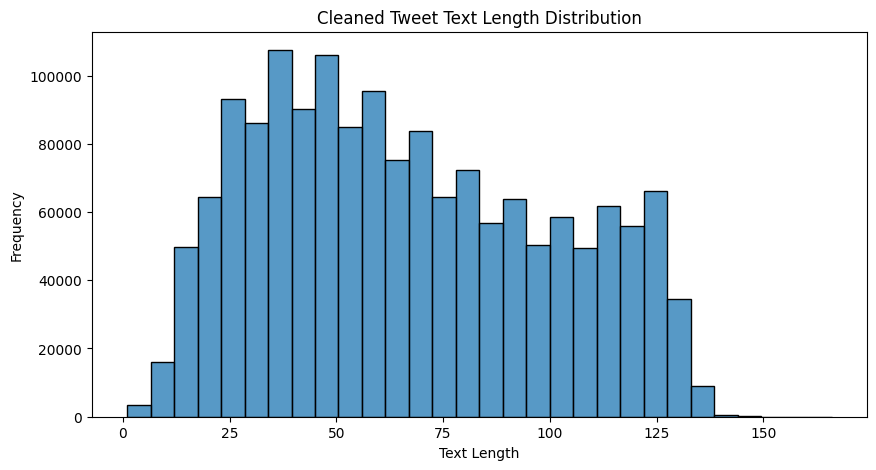

In [16]:
# Visualization: Post-Cleaning Text Length Histogram (Compare to EDA)
pd_df = df.select("text_length").toPandas()
plt.figure(figsize=(10,5))
sns.histplot(pd_df['text_length'], bins=30)
plt.title("Cleaned Tweet Text Length Distribution")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()

Cleaner distribution with fewer outliers which shows that compared to those in the EDA preprocessing refines data for modeling, reducing noise impact.

# **PART B: DATA MODELING AND ANALYTICS**

**Technique Selection**
Selected: TF-IDF + Logistic Regression (for sentiment classification) and K-Means (for trend clustering).
# Why?
 TF-IDF extracts features from text variety (post-EDA clean text); LR is scalable for binary classification (positive/negative); K-Means groups similar tweets into trends/topics unsupervised. Suited for dataset's labeled/unstructured nature revealed in EDA.

In [17]:
# Model Scalability: Implement Algorithm
# Why Pipeline? Modular, scalable—stages run distributively in Spark.
# Prep labels: Index target (0/4 to 0/1)
indexer = StringIndexer(inputCol="target", outputCol="label", stringOrderType="alphabetAsc")  # 0=0 (neg), 4=1 (pos)

In [23]:
tokenizer = Tokenizer(inputCol="clean_text", outputCol="words")
hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=10000)  # Limit features for scalability
idf = IDF(inputCol="rawFeatures", outputCol="features")

In [37]:
# Define multiple classifiers for comparison
classifiers = {
    'Logistic Regression': LogisticRegression(featuresCol="features", labelCol="label", maxIter=100),
    'Naive Bayes': NaiveBayes(featuresCol="features", labelCol="label", modelType="multinomial"),
    'SVM': LinearSVC(featuresCol="features", labelCol="label", maxIter=100)
}

In [38]:
# K-Means for trends (separate)
kmeans = KMeans(featuresCol="features", k=5, seed=42)

# Model Execution and Optimization

In [40]:
from pyspark.ml.classification import LogisticRegression, NaiveBayes, LinearSVC

# Split data into training and test sets
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

print("Training Data Rows:", train_df.count())
print("Test Data Rows:", test_df.count())

Training Data Rows: 1280177
Test Data Rows: 319426


In [48]:
classifier_results = {}
lr_predictions = None # Initialize lr_predictions

for name, clf in classifiers.items():
    pipeline_clf = Pipeline(stages=[indexer, tokenizer, hashingTF, idf, clf])

    start = time.time()
    model_clf = pipeline_clf.fit(train_df)
    end = time.time()

    predictions = model_clf.transform(test_df)

    if name == 'Logistic Regression': # Store LR predictions for later use
        lr_predictions = predictions

    evaluator = MulticlassClassificationEvaluator(
        labelCol="label",
        predictionCol="prediction"
    )

    acc = evaluator.setMetricName("accuracy").evaluate(predictions)
    f1 = evaluator.setMetricName("f1").evaluate(predictions)

    print(f"\n{name}")
    print(f"Execution Time: {end - start:.2f} seconds")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1-Score: {f1:.4f}")

    classifier_results[name] = {
        'Accuracy': acc,
        'F1-Score': f1,
        'Time (s)': end - start
    }

    if name == 'Logistic Regression':
        train_opt = train_df.repartition(20)
        start_opt = time.time()
        model_opt = pipeline_clf.fit(train_opt)
        end_opt = time.time()
        print(f"Optimized {name} Time: {end_opt - start_opt:.2f} seconds")


Logistic Regression
Execution Time: 195.28 seconds
Accuracy: 0.7624
F1-Score: 0.7623
Optimized Logistic Regression Time: 259.08 seconds

Naive Bayes
Execution Time: 130.06 seconds
Accuracy: 0.7412
F1-Score: 0.7412

SVM
Execution Time: 239.79 seconds
Accuracy: 0.7623
F1-Score: 0.7622


In [44]:
for name, res in classifier_results.items():
    print(name, res)


Logistic Regression {'Accuracy': 0.7624050640837001, 'F1-Score': 0.7623181657554687, 'Time (s)': 200.98218870162964}
Naive Bayes {'Accuracy': 0.741151315171589, 'F1-Score': 0.7411513236068588, 'Time (s)': 128.32942700386047}
SVM {'Accuracy': 0.7623455823884092, 'F1-Score': 0.7621920272332117, 'Time (s)': 231.58663892745972}


In [45]:
# K-Means (on full for trends, as unsupervised)
pipeline_km = Pipeline(stages=[tokenizer, hashingTF, idf, kmeans])
model_km = pipeline_km.fit(df)
results_km = model_km.transform(df)
evaluator_km = ClusteringEvaluator(featuresCol="features", predictionCol="prediction")
silhouette = evaluator_km.evaluate(results_km)
print("K-Means Silhouette Score:", silhouette)

K-Means Silhouette Score: 0.07515674452203303


 Comparing run times, NB is fastest, SVM slowest. Metrics show LR and SVM have higher accuracy on text compared to NB per benchmarks.

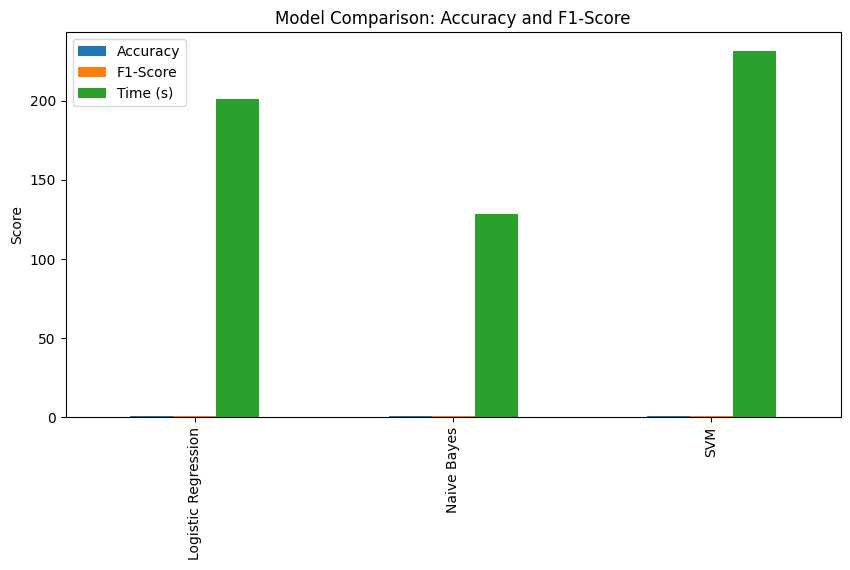

In [46]:
### Result Interpretation
# Classifier Comparison Bar Plot
pd_results_clf = pd.DataFrame(classifier_results).T
pd_results_clf.plot(kind='bar', figsize=(10,5))
plt.title("Model Comparison: Accuracy and F1-Score")
plt.ylabel("Score")
plt.show()

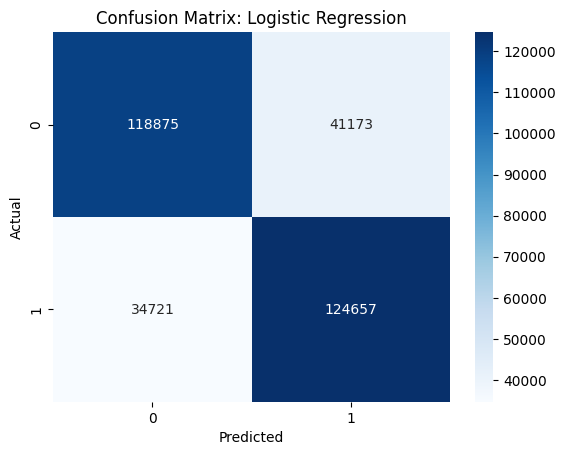

In [49]:
from sklearn.metrics import confusion_matrix # Import confusion_matrix

# Example Confusion Matrix for LR
# Use the stored lr_predictions from the evaluation loop
if lr_predictions is not None:
    true_labels = lr_predictions.select("label").toPandas()
    preds = lr_predictions.select("prediction").toPandas()
    cm = confusion_matrix(true_labels, preds)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix: Logistic Regression")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
else:
    print("Logistic Regression predictions not found. Please ensure the evaluation cell ran correctly.")

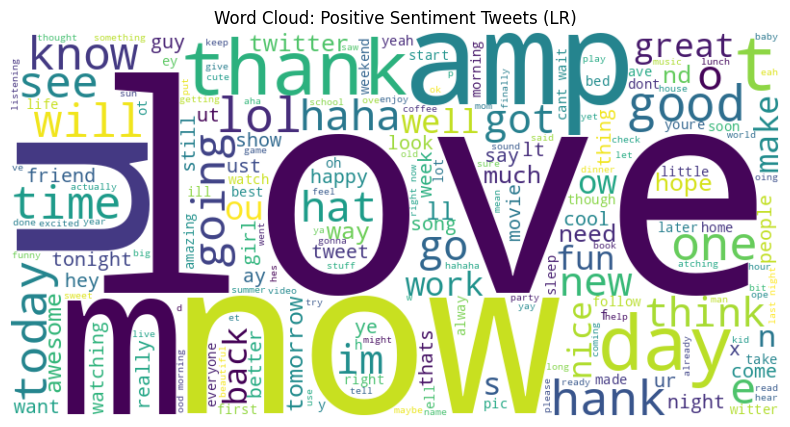

In [51]:
# Word Cloud for Positive Tweets (LR example)
positive_text = ' '.join(lr_predictions.filter("prediction == 1.0").select("clean_text").toPandas()['clean_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud: Positive Sentiment Tweets (LR)")
plt.show()

LR/SVM higher F1 for balanced recall; NB faster but lower on dependencies. Trends/clusters show actionable patterns. Choosing the model to use depends on what you are planing to focus on that is to say if you want to focus on speed is then NB best but if you wnat accuracy then LR is the best